In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GaussianMixture
from scipy.optimize import curve_fit

In [24]:
data = pd.read_csv("data_rev.csv", comment='#',sep=',')

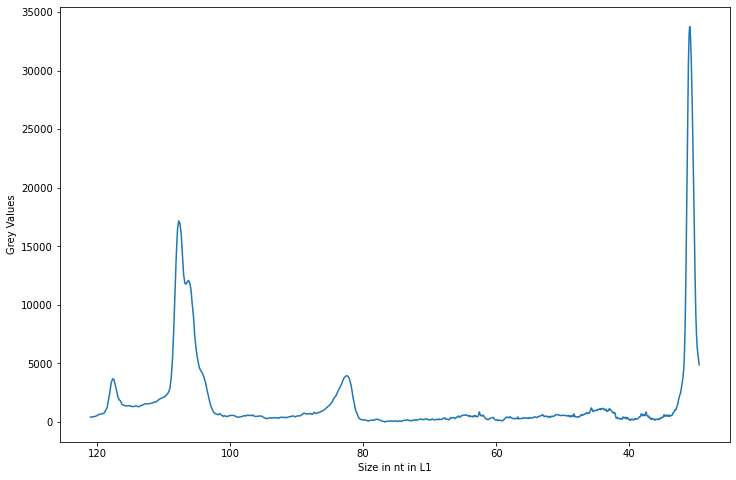

In [26]:
plt.figure(figsize=(12, 8))
initial_plot = plt.plot(data.iloc[:,0], data.iloc[:,1])
ax = plt.gca().invert_xaxis()
plt.xlabel("Size in nt in L1")
plt.ylabel("Grey Values")
plt.show()

In [27]:
cut_data=data[49:100]
cut_data

,Size in nt in L1,Grey Values
49,111.130974,1702.929
50,110.938741,1824.572
51,110.746840,1879.714
52,110.555271,1981.357
53,110.364034,2018.714
54,110.173127,2078.214
55,109.982551,2120.214
56,109.792304,2172.429
57,109.602386,2297.643
58,109.412797,2379.000


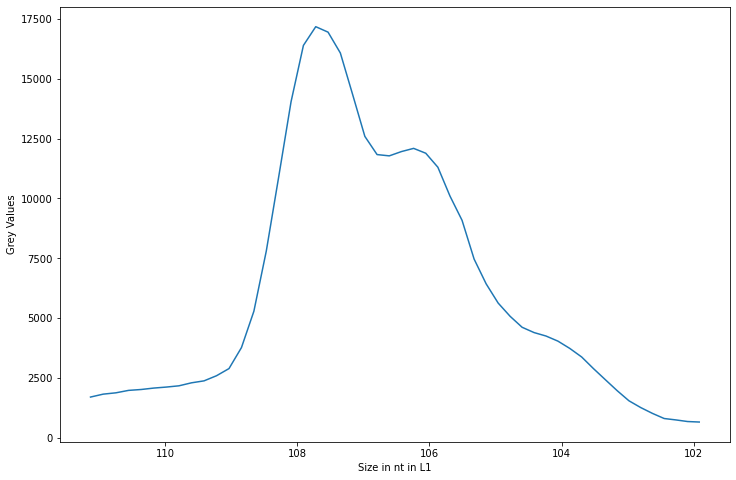

In [28]:
plt.figure(figsize=(12, 8))
initial_plot = plt.plot(cut_data['Size in nt in L1'], cut_data['Grey Values'])
ax = plt.gca().invert_xaxis()
plt.xlabel("Size in nt in L1")
plt.ylabel("Grey Values")
plt.show()

In [29]:
# instantiating a the model and fitting it to the data
gmm_learning =GaussianMixture(n_components=len(cut_data), covariance_type='full').fit(cut_data.dropna().values)

C:\Users\Marius\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [30]:
# generating 1000 data points based on the learning
generated_distribution = gmm_learning.sample(1000)[0]

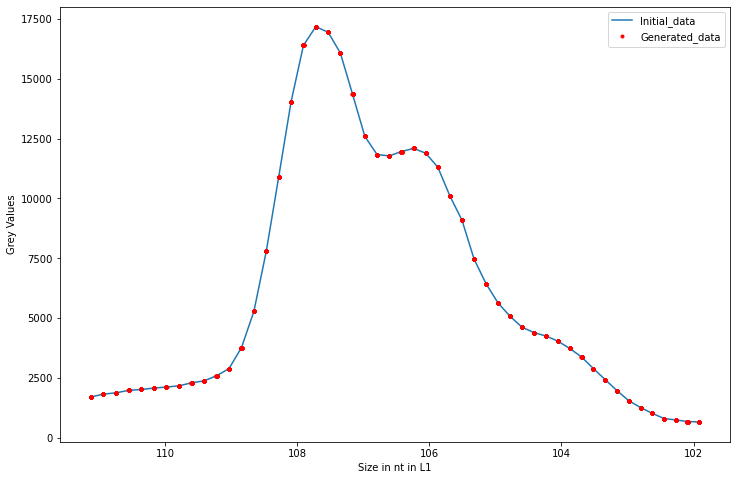

In [31]:
plt.figure(figsize=(12, 8))
new_plot = plt.plot(cut_data['Size in nt in L1'], cut_data['Grey Values'], label='Initial_data')
plt.plot(generated_distribution[:,0],generated_distribution[:,1],'r.',label='Generated_data')
ax = plt.gca().invert_xaxis()
plt.xlabel("Size in nt in L1")
plt.ylabel("Grey Values")
plt.legend()
plt.show()

In [32]:
def gmmClustering(generateddata,nComponents):
    """Performs clustering on given distribution
    Args:
        generatedData(df): columns =[LogM,dwdlogM]
        nComponents(int): the number of clusters to identify
    returns: 
        list: [weight, mean,standard deviation] of each cluster 
    """
    # creating a model and fitting the model to the data
    gmm =GaussianMixture(n_components=nComponents, covariance_type='full').fit(generateddata) 
    mean = gmm.means_[:,0] # the first columns contains the means   
    #covariance returns a set of arrays each for one cluster. The main diagonal contains the variance
    covariance = gmm.covariances_    
    # the weights here are the population fractions
    weight = gmm.weights_
    
    cluster_parms =[] # to store the cluster parameters
    for i in range(nComponents):
        cluster_parms.append([weight[i],mean[i],np.sqrt(np.diag(covariance[i]))[0]])
    return list(np.hstack(cluster_parms))

In [33]:
# writing the gaussian function
def gaussian_func(x,*params):
    """ generate the gaussian distribution"""
    y = np.zeros_like(x)
    for i in range(0,len(params),3):
        amp= params[i] # amplitude
        ctr = params[i+1] # peak location
        width = params[i+2] # standard deviation
        y += amp*np.exp(-((x-ctr)/width)**2)
    return y

In [34]:
number_of_clusters = 2
clusters_params2 = gmmClustering(generated_distribution,nComponents=number_of_clusters)

C:\Users\Marius\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [35]:
def optimizeGmmParameter(rawdata, gmm_parameters,gaussFunct):
  
    x_raw = rawdata.iloc[:,0].dropna().values;y_raw=rawdata.iloc[:,1].dropna().values
    
    # returns the fitting parameters, accepts the function,data and init_para
    popt_gauss, pcov_gauss = curve_fit(gaussFunct, x_raw, y_raw, p0=gmm_parameters, maxfev = 50000)
    optimizedParameter = np.asarray(popt_gauss).reshape(-1,3)
    return sorted(optimizedParameter, key= lambda x: x[1])

In [36]:
optimized_parms2 = optimizeGmmParameter(cut_data, clusters_params2,gaussian_func)

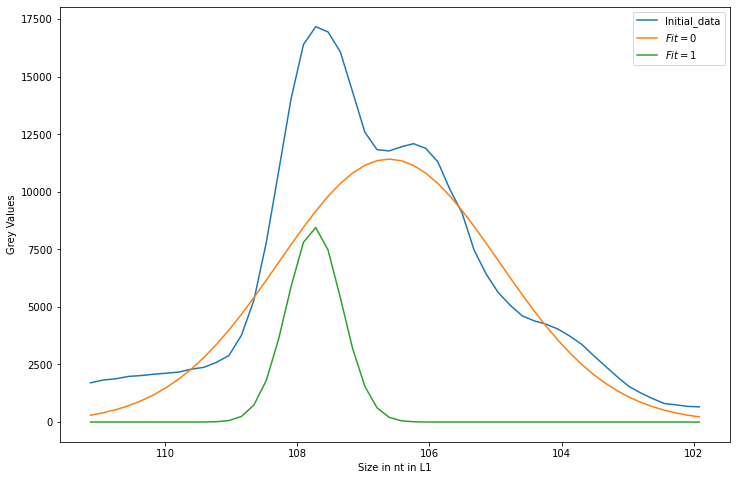

In [37]:
plt.figure(figsize=(12, 8))
new_plot = plt.plot(cut_data['Size in nt in L1'], cut_data['Grey Values'], label='Initial_data')
for i in range(len(optimized_parms2)):
    plt.plot(cut_data.iloc[:,0],gaussian_func(cut_data.iloc[:,0],*optimized_parms2[i]), label='$Fit = {i}$'.format(i=i))

ax = plt.gca().invert_xaxis()
plt.xlabel("Size in nt in L1")
plt.ylabel("Grey Values")
plt.legend()
plt.show()

C:\Users\Marius\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


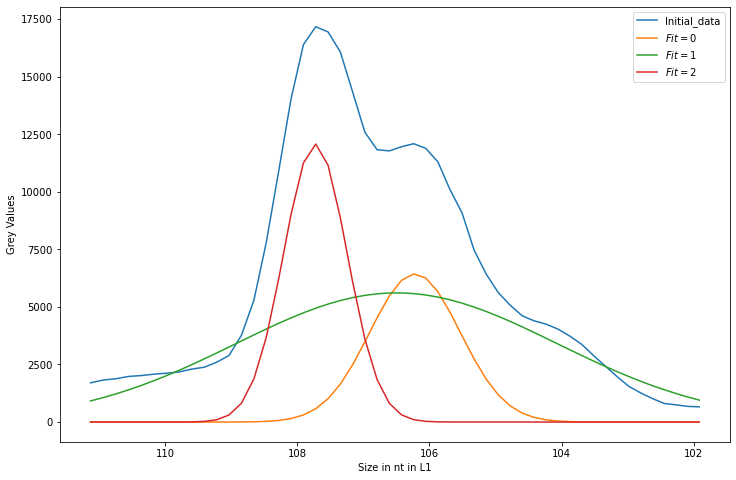

In [74]:
# performing clustering
number_of_clusters = 3
clusters_params3 = gmmClustering(generated_distribution,nComponents=number_of_clusters)
# performing curve fitting
optimized_parms3 = optimizeGmmParameter(cut_data, clusters_params3,gaussian_func)

plt.figure(figsize=(12, 8))
new_plot = plt.plot(cut_data['Size in nt in L1'], cut_data['Grey Values'], label='Initial_data')
for i in range(len(optimized_parms3)):
    plt.plot(cut_data.iloc[:,0],gaussian_func(cut_data.iloc[:,0],*optimized_parms3[i]), label='$Fit = {i}$'.format(i=i))

ax = plt.gca().invert_xaxis()
plt.xlabel("Size in nt in L1")
plt.ylabel("Grey Values")
plt.legend()
plt.show()

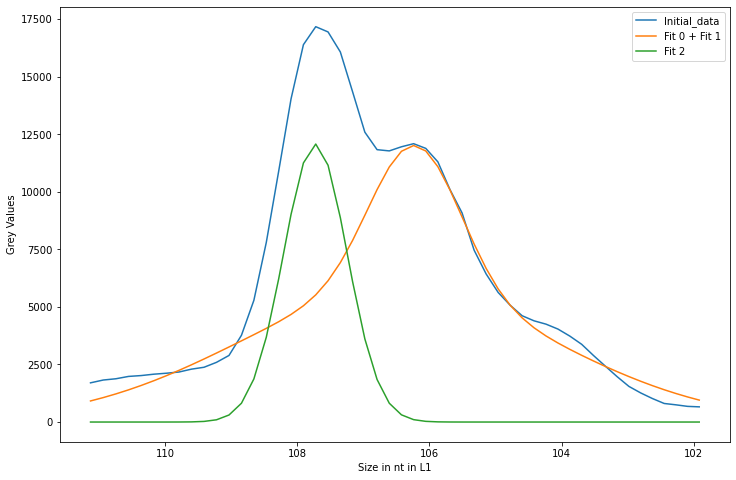

In [77]:
#combining two distribution peaks together to check if we get better representation
x_values = cut_data.iloc[:,0]
lower_portion = gaussian_func(x_values,*optimized_parms3[0])+ gaussian_func(cut_data.iloc[:,0],*optimized_parms3[1])
higher_portion = gaussian_func(x_values,*optimized_parms3[-1])

plt.figure(figsize=(12, 8))
new_plot = plt.plot(cut_data['Size in nt in L1'], cut_data['Grey Values'], label='Initial_data')
plt.plot(x_values,lower_portion, label='Fit 0 + Fit 1')
plt.plot(x_values,higher_portion, label='Fit 2')
ax = plt.gca().invert_xaxis()
plt.xlabel("Size in nt in L1")
plt.ylabel("Grey Values")
plt.legend()
plt.show()

C:\Users\Marius\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


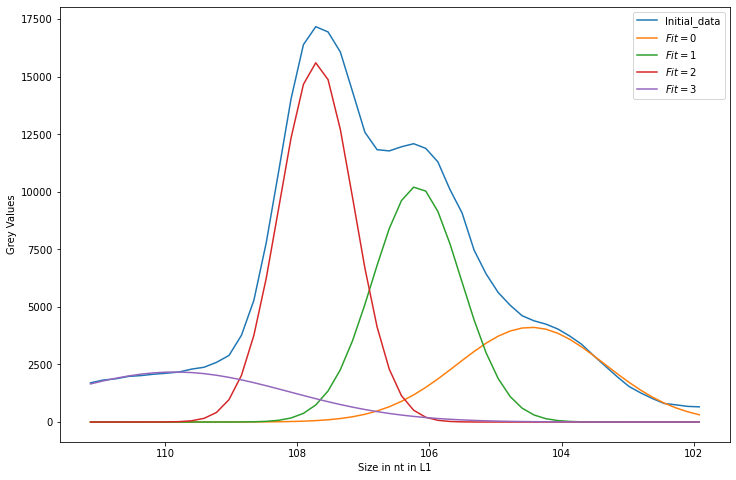

In [81]:
# performing clustering
number_of_clusters = 4
clusters_params4 = gmmClustering(generated_distribution,nComponents=number_of_clusters)
# performing curve fitting
optimized_parms4 = optimizeGmmParameter(cut_data, clusters_params4,gaussian_func)

plt.figure(figsize=(12, 8))
new_plot = plt.plot(cut_data['Size in nt in L1'], cut_data['Grey Values'], label='Initial_data')
for i in range(len(optimized_parms4)):
    plt.plot(cut_data.iloc[:,0],gaussian_func(cut_data.iloc[:,0],*optimized_parms4[i]), label='$Fit = {i}$'.format(i=i))

ax = plt.gca().invert_xaxis()
plt.xlabel("Size in nt in L1")
plt.ylabel("Grey Values")
plt.legend()
plt.show()

C:\Users\Marius\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\Marius\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


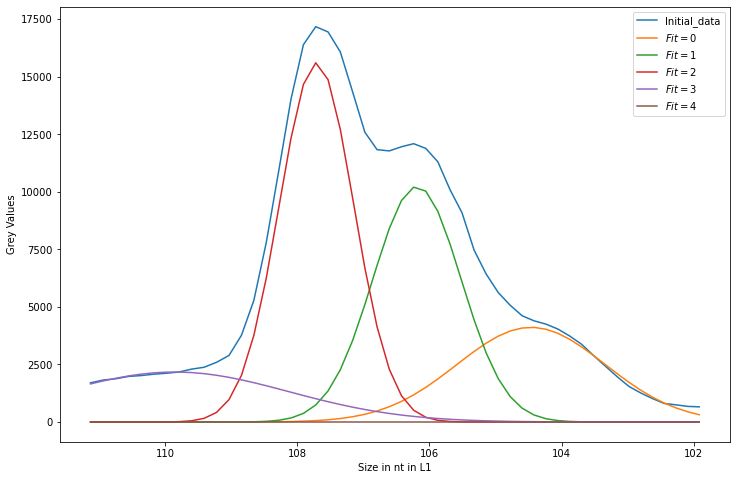

In [86]:
# performing clustering
number_of_clusters = 5
clusters_params5 = gmmClustering(generated_distribution,nComponents=number_of_clusters)
# performing curve fitting
optimized_parms5 = optimizeGmmParameter(cut_data, clusters_params5,gaussian_func)

plt.figure(figsize=(12, 8))
new_plot = plt.plot(cut_data['Size in nt in L1'], cut_data['Grey Values'], label='Initial_data')
for i in range(len(optimized_parms5)):
    plt.plot(cut_data.iloc[:,0],gaussian_func(cut_data.iloc[:,0],*optimized_parms5[i]), label='$Fit = {i}$'.format(i=i))

ax = plt.gca().invert_xaxis()
plt.xlabel("Size in nt in L1")
plt.ylabel("Grey Values")
plt.legend()
plt.show()

C:\Users\Marius\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


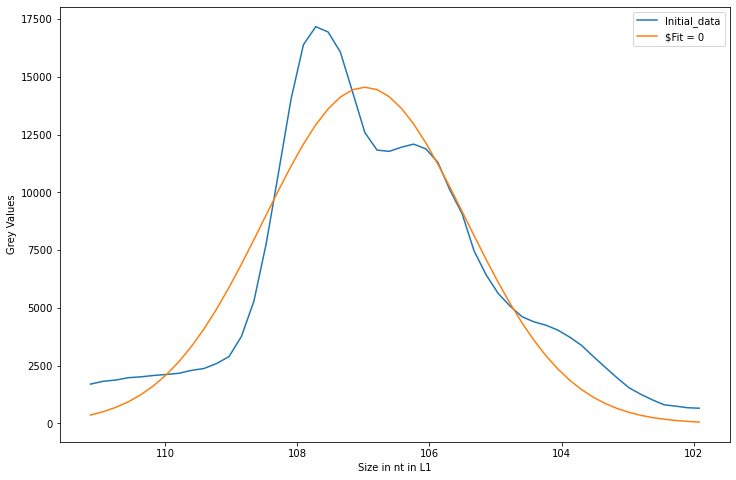

In [88]:
# performing clustering
number_of_clusters = 1
clusters_params1 = gmmClustering(generated_distribution,nComponents=number_of_clusters)
# performing curve fitting
optimized_parms1 = optimizeGmmParameter(cut_data, clusters_params1,gaussian_func)

plt.figure(figsize=(12, 8))
new_plot = plt.plot(cut_data['Size in nt in L1'], cut_data['Grey Values'], label='Initial_data')
for i in range(len(optimized_parms1)):
    plt.plot(cut_data.iloc[:,0],gaussian_func(cut_data.iloc[:,0],*optimized_parms1[i]), label='Fit = 0')

ax = plt.gca().invert_xaxis()
plt.xlabel("Size in nt in L1")
plt.ylabel("Grey Values")
plt.legend()
plt.show()